# Purpose
* Want to reproduce the summary stats from [PyMC3 3.6 Joint distributions](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/BCM/ParameterEstimation/Binomial.ipynb#3.6-Joint-distributions) from the [book Bayesian Cognitive Modeling](https://bayesmodels.com/)
* the example was inspired from the post by [yongduek on the Pyro fourm](https://forum.pyro.ai/t/latent-categorical/2695/6?u=bdatko)
* If you need sometihng similar look at [Predictive](http://num.pyro.ai/en/latest/utilities.html#predictive) and [Example: Bayesian Models of Annotation](http://num.pyro.ai/en/latest/examples/annotation.html) from commit [Support infer_discrete for Predictive (#1086)](https://github.com/pyro-ppl/numpyro/commit/003424bb3c57e44b433991cc73ddbb557bf31f3c)

In [1]:
import arviz as az
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs
from numpyro.infer.util import Predictive

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark

In [3]:
%watermark -v -m -p arviz,jax,numpy,pandas,numpyro

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.18.1

arviz  : 0.11.2
jax    : 0.2.19
numpy  : 1.20.3
pandas : 1.3.2
numpyro: 0.7.2

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.193-1-MANJARO
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit



In [4]:
%watermark -gb

Git hash: 9d0a32bcbadc679ee3a8a1e99de41903559e58d5

Git branch: master



In [5]:
rng_key = jax.random.PRNGKey(2)
keys = jax.random.split(rng_key, 4)

num_warmup = 1000
num_samples = 5000
num_chains = 4

### Discrete `n`

In [6]:
def model36(a, b, probs, k=None):
    # priors: th, n
    n = numpyro.sample("n", dist.Categorical(probs=probs))
    th = numpyro.sample("th", dist.Beta(a, b))
    # observation
    size = len(k)
    with numpyro.plate(f"i=1..{size}", size=size):
        obs = numpyro.sample("k", dist.Binomial(total_count=n, probs=th), obs=k)


a, b = 1, 1
k = jnp.array([16, 18, 22, 25, 27])
nmax = 500
probs = jnp.array([1.0] * nmax) / nmax

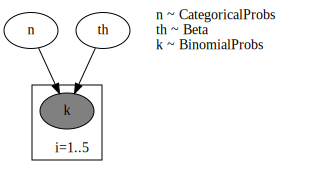

In [7]:
numpyro.render_model(model36, (a, b, probs, k), render_distributions=True)

In [8]:
kernel = numpyro.infer.DiscreteHMCGibbs(NUTS(model36), modified=True)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(keys[0], a=b, b=b, probs=probs, k=k)
mcmc.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 6000/6000 [00:03<00:00, 1779.29it/s, 3 steps of size 7.94e-02. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         n    191.72    133.28    155.00     30.00    409.00     59.22      1.07
        th      0.20      0.16      0.14      0.04      0.46     49.10      1.09



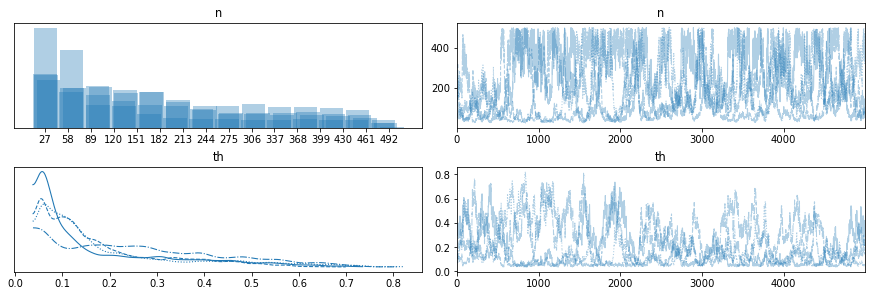

In [9]:
ds = az.from_numpyro(mcmc)
az.plot_trace(ds);

### Discrete `n`
#### Using `Predictive`

In [10]:
from numpyro.infer.util import Predictive

In [11]:
kernel = NUTS(model36)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(keys[1], a=b, b=b, probs=probs, k=k)
mcmc.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 6000/6000 [00:05<00:00, 1151.82it/s, 3 steps of size 6.42e-01. acc. prob=0.74]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        th      0.19      0.15      0.14      0.04      0.41   3984.09      1.00

Number of divergences: 123


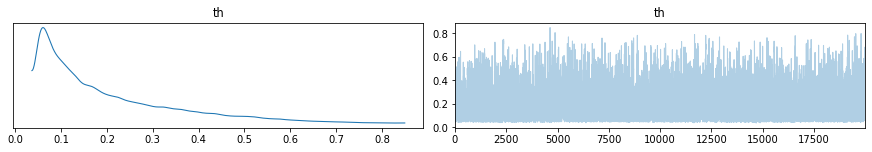

In [12]:
az.plot_trace(mcmc.get_samples());

In [13]:
posterior_samples = mcmc.get_samples()
predictive = Predictive(
    model36, posterior_samples, infer_discrete=True, batch_ndims=num_chains
)
discrete_samples = predictive(keys[2], *(a, b, probs, k))

In [14]:
az.stats.summary(
    np.array(discrete_samples["n"].reshape(num_chains, num_samples)), hdi_prob=0.9
)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,187.419,125.497,29.0,388.0,1.914,1.353,4034.0,5607.0,1.0


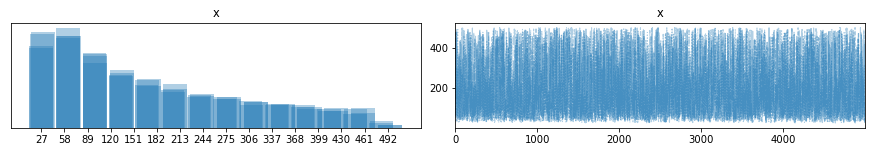

In [15]:
az.plot_trace(np.array(discrete_samples["n"].reshape(num_chains, num_samples)));

### Continous `n`
Quote below is from [PyMC3 notebook Chapter 3 - Inferences with binomials - Section: Note from Junpeng Lao](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/BCM/ParameterEstimation/Binomial.ipynb#Note-from-Junpeng-Lao)
> Actually, we don't necessary need to use DiscreteUniform for TotalN, as the computation of logp in Binomial doesn't require n to be an integer.

In [16]:
def modelu(a, b, nmax, k=None):
    u = numpyro.sample("u", dist.Uniform())
    n = u * nmax
    numpyro.deterministic("n", n)
    th = numpyro.sample("th", dist.Beta(a, b))
    size = len(k)
    with numpyro.plate(f"i=1..{size}", size=size):
        obs = numpyro.sample("k", dist.Binomial(total_count=n, probs=th), obs=k)

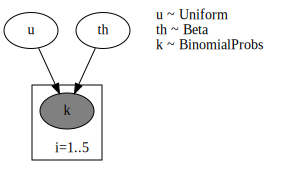

In [17]:
# I guess the render doesn't track deterministic values...
numpyro.render_model(modelu, (a, b, nmax, k), render_distributions=True)

In [18]:
kernel = NUTS(modelu)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(keys[3], a=b, b=b, nmax=nmax, k=k)
mcmc.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 6000/6000 [00:01<00:00, 4361.88it/s, 31 steps of size 8.61e-02. acc. prob=0.76]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        th      0.68      0.40      1.00      0.08      1.00       nan      1.92
         u      0.15      0.24      0.02      0.00      0.55      8.25      1.32

Number of divergences: 130


In [19]:
ds = az.from_numpyro(mcmc)

In [20]:
az.stats.summary(ds["posterior"]["n"], hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
n,75.959,121.913,0.007,275.356,38.809,28.296,8.0,64.0,1.95


/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5


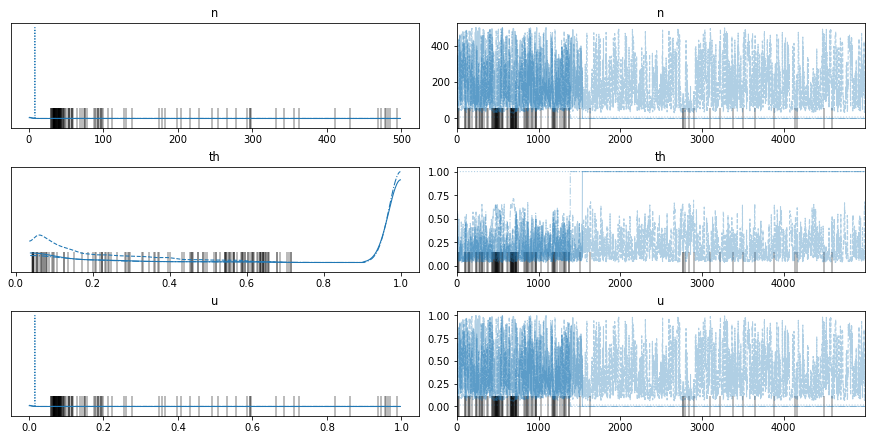

In [21]:
az.plot_trace(ds);